# Skin Cancer Classification

### Import Relevant Packages

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import PIL.Image as img
from keras.layers import Dense, Conv2D , MaxPool2D , Dropout , Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import os
from glob import glob
import math
from imblearn import over_sampling, under_sampling
from IPython.display import display

#### Personal Notes:

I'm a little worried about runtime, so I may make a switch to using grayscale images. RGB is 3 times the size and I'm not sure how that'll play out. Hopefully we don't have to make the compromise, because I think color is important in this data, but I'm keeping it in mind! As an aside, here are what each number in the "label" column corresponds to:
```
0: nv - Melanocytic nevi
1: mel - Melanoma
2: bkl - Benign keratosis-like lesions
3: bcc - Basal cell carcinoma
4: akiec - Actinic keratoses and intraepithelial carcinoma / Bowen's disease
5: vasc - Vascular lesions
6: df - Dermatofibroma
```
The abbreviations are given in the original metadata under the "dx" column; I make these diagnoses clearer in the modified dataset.

We also need to split along proportion in the training and testing sets -- it wouldn't do to have differing class representations in each. Similarly, we ought to downsample #4. 

## Read in Dataset

In [3]:
data = pd.read_csv("./data/hmnist_28_28_L.csv")
metadata = pd.read_csv("./data/HAM10000_metadata.csv")

# Normalize data:
#data_normalized = data / 255

metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


We normalize the dataset because we want to get a value as a *percentage* of brightness, rather than a specific luma key. I've done some analysis on this to know that we don't have any issues, as would be expected for a dataset cultivated for machine learning rather than "real-world" data. I'll likely do more to figure out what kind of distributions exist across cancer type, gender, cancer location, etc. For now though, let's do the fun stuff!

## Metadata Analysis

In [4]:
metadata.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

Good to know! It looks like we've got 57 cases whose age was not recorded. This is a low enough number that I feel comfy replacing these missing ages with the mean age across the whole dataset. I'm using imputation rather than removal because I want to use as much available data as possible. 

In [5]:
# Fill na values "age" variable
metadata["age"].fillna(metadata["age"].mean(), inplace = True)
metadata.isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [6]:
# Check work with .describe:
metadata["age"].describe()

count    10015.000000
mean        51.863828
std         16.920252
min          0.000000
25%         40.000000
50%         50.000000
75%         65.000000
max         85.000000
Name: age, dtype: float64

Interesting... we have some cases where the recorded age is zero!! It's unlikely (I think, at least; I'm not really an expert in pediatric oncology) to have a patient who is truly less than a year old in for skin cancer, so I'm going to assume that these cases are simply a mixup in data entry -- some unknown ages were input as NA, some unknown ages were input as 0. Let's fix that too.

#### First, let's check how many 0s we have....

In [7]:
metadata["age"].value_counts()[0]

39

Well that's okay, only 39 zeros! I wanted to check and make sure -- it's always nasty if they make up some absurd number like 1/2 the dataset!

In [8]:
metadata["age"] = metadata["age"].replace(0, metadata["age"].mean())
metadata["age"].describe()

count    10015.000000
mean        52.065794
std         16.606576
min          5.000000
25%         40.000000
50%         50.000000
75%         65.000000
max         85.000000
Name: age, dtype: float64

In [9]:
data.groupby("label").count()["pixel0001"]

label
0     327
1     514
2    1099
3     115
4    6705
5     142
6    1113
Name: pixel0001, dtype: int64

This data is weighted funny... we'll need to make sure that we find a way around this statistically; too many actinic keratoses cases may skew our predictive capacity. There's got to be a way around it, but I'll check with Cheng on Thursday after class.

Note: Found the solution! I need to come up with a way to select proportionally, or maybe I'll do it with class weights. It might be a little unorthodox to do for a majority column, but we'll give it a go.  

## Merge datasets

I want to make sure that I can keep all data contained in the same dataframe so we can perform a more detailed analysis. I've decided to provide specific names for each skin lesion abbreviation to make my visualizations clearer, and included the image path in the dataframe to make it simpler to find and plot images. I add the label column because each skin lesion is associated with a numeric label code in the pre-built image arrays. In the event I want to use one of these other datasets, I want the switch to be as smooth as possible. Moreover, I will need to one-hot encode the label column to use it in a CNN like I intend to, and readability is helped by making similar changes all at the same time.

In [10]:
# Create lesion type dataset:

cancer_types_dict = {
    "akiec" : "Actinic Keratoses",
    "bcc" : "Basal Cell Carcinoma",
    "bkl" : "Benign Keratosis-like Lesions",
    "df" : "Dermatofibroma",
    "mel" : "Melanoma",
    "nv" : "Melanocytic Nevi",
    "vasc" : "Vascular Lesions"
}

# Create dict of img paths:
base_skin_set = os.getcwd() # this should work for everybody, so long as the file is in the "data" folder!

image_id_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_set, '*', '*.jpg'))} # This is modified stack-overflow code, but it works!

In [11]:
# Create modified dataframe:
mod_data = metadata

mod_data["Cell_Type"] = mod_data['dx'].map(cancer_types_dict.get)
mod_data["Path"] = mod_data["image_id"].map(image_id_path_dict.get)
mod_data["Label"] = pd.Categorical(mod_data['Cell_Type']).codes # Aligns data labels with .csv files in original download
mod_data.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,Cell_Type,Path,Label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign Keratosis-like Lesions,c:\Users\new owner\Documents\GitHub\fluffy-dis...,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign Keratosis-like Lesions,c:\Users\new owner\Documents\GitHub\fluffy-dis...,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign Keratosis-like Lesions,c:\Users\new owner\Documents\GitHub\fluffy-dis...,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign Keratosis-like Lesions,c:\Users\new owner\Documents\GitHub\fluffy-dis...,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign Keratosis-like Lesions,c:\Users\new owner\Documents\GitHub\fluffy-dis...,2
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,Benign Keratosis-like Lesions,c:\Users\new owner\Documents\GitHub\fluffy-dis...,2
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,Benign Keratosis-like Lesions,c:\Users\new owner\Documents\GitHub\fluffy-dis...,2
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,Benign Keratosis-like Lesions,c:\Users\new owner\Documents\GitHub\fluffy-dis...,2
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,Benign Keratosis-like Lesions,c:\Users\new owner\Documents\GitHub\fluffy-dis...,2
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,Benign Keratosis-like Lesions,c:\Users\new owner\Documents\GitHub\fluffy-dis...,2


In [12]:
# Check for NA values in "Path"
print(mod_data[mod_data["Path"].isna()])

Empty DataFrame
Columns: [lesion_id, image_id, dx, dx_type, age, sex, localization, Cell_Type, Path, Label]
Index: []


### Plot Images From Modified Data
We'll want to groupby the type of cancer so we can display the entirity of available specimens instead of benign keratosis-like lesions alone. 

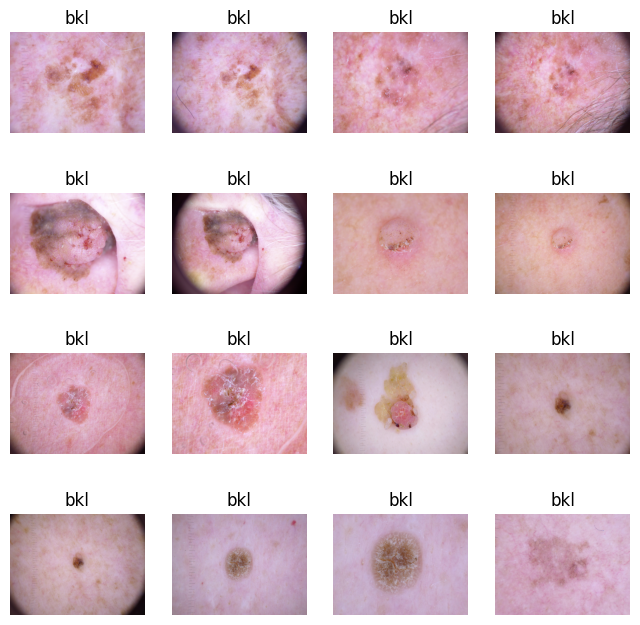

In [13]:
plt.figure(figsize = (8,8))

for i in range(16):
    plt.subplot(4,4, i + 1)
    x = plt.imread(mod_data.Path[i])
    plt.axis("off")
    plt.title(mod_data.dx[i])
    plt.imshow(x)

In [ ]:
# Let's check our incoming image size:
image = img.open(mod_data["Path"][0]) # I use 1 because the 0th index of "Path" is in  X_test
print(f"Image Size: {image.size}")

Image Size: (600, 450)


Good to know -- this is likely to be to big to be efficient given our limitations. We'll need to resize.

### Flow From Dataframe

In [18]:
# Flow From Dataframe
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(rescale = 1.0 / 255, validation_split = 0.3)

# Training
x_gen = gen.flow_from_dataframe(dataframe = mod_data, x_col = "Path", y_col = "dx", target_size = (128, 128), batch_size = 32, subset = "training", 
                                class_mode = "categorical", seed = 1729)
# Testing
y_gen = gen.flow_from_dataframe(dataframe = mod_data, x_col = "Path", y_col = "dx", target_size = (128, 128), batch_size = 32, subset = "validation", 
                                class_mode = "categorical", seed = 1729)

Found 7011 validated image filenames belonging to 7 classes.
Found 3004 validated image filenames belonging to 7 classes.


This code draws from the dataframe "mod_data", selecting the image path as the variable and dx as the label, one-hot enocoding the label in the process. The image is reshaped to (128, 128) and normalized so values are between 0 & 1. The validation split is 70-30; I intend to draw from a harvard repository of similar skin cancer images as a final testing set. This draws the images in a more memory efficient manner than the .map(lambda: x ...) stratagem I employed earlier. This less efficent method is commented out below, but kept for the sake of preservation.

### Over and UnderSampling Data


So, here's where we stand. Right now, we've got all the data fixed up and in a position where we can start building a model, but there's still a problem here. We have massive class imbalances in this dataset; Melanocytic Nevi makes up more than HALF of our samples! Ergo, we're going to test over and undersampling out to see how they look

In [15]:
# This block of code oversamples the data
"""
# Define number of classes
CLASSES = len(np.unique(mod_data["Cell_Type"]))

# Individual class probabilities in dataset
display(print("Invidual Probabilities:"), mod_data["Cell_Type"].value_counts() / len(mod_data))

# Ideal uniform class probability
display(print("Ideal Uniform:"), 1 / CLASSES)

# Resample data to even class probabilies
oversample = over_sampling.RandomOverSampler()
mod_data, mod_data["Label"] = oversample.fit_resample(mod_data, mod_data["Label"])

# Display Resampled Probs.
display(print("Invidual Probabilities After Resampling:"), mod_data["Cell_Type"].value_counts() / len(mod_data))
"""

'\n# Define number of classes\nCLASSES = len(np.unique(mod_data["Cell_Type"]))\n\n# Individual class probabilities in dataset\ndisplay(print("Invidual Probabilities:"), mod_data["Cell_Type"].value_counts() / len(mod_data))\n\n# Ideal uniform class probability\ndisplay(print("Ideal Uniform:"), 1 / CLASSES)\n\n# Resample data to even class probabilies\noversample = over_sampling.RandomOverSampler()\nmod_data, mod_data["Label"] = oversample.fit_resample(mod_data, mod_data["Label"])\n\n# Display Resampled Probs.\ndisplay(print("Invidual Probabilities After Resampling:"), mod_data["Cell_Type"].value_counts() / len(mod_data))\n'

Okay, so here's where we're at. The above block of code functions as it is meant to, however, it produces a LOT of extra data. A LOT. We jump from 10,015 data points to 46,935!! That's a pretty nasty amount of data to work with, and is forcing me to reconsider how we approach our runtime issues. At the moment, I'm thinking that we try an undersampling technique, and see where that gets us. 

In [16]:
# This block of code undersamples the data
"""
CLASSES = len(np.unique(mod_data["Cell_Type"]))

# Individual class probabilities in dataset
display(print("Invidual Probabilities:"), mod_data["Cell_Type"].value_counts() / len(mod_data))

undersampler  = under_sampling.RandomUnderSampler()

mod_data, mod_data["Label"] = undersampler.fit_resample(mod_data, mod_data["Label"])

# Display Resampled Probs.
display(print("Invidual Probabilities After Resampling:"), mod_data["Cell_Type"].value_counts() / len(mod_data))
"""

'\nCLASSES = len(np.unique(mod_data["Cell_Type"]))\n\n# Individual class probabilities in dataset\ndisplay(print("Invidual Probabilities:"), mod_data["Cell_Type"].value_counts() / len(mod_data))\n\nundersampler  = under_sampling.RandomUnderSampler()\n\nmod_data, mod_data["Label"] = undersampler.fit_resample(mod_data, mod_data["Label"])\n\n# Display Resampled Probs.\ndisplay(print("Invidual Probabilities After Resampling:"), mod_data["Cell_Type"].value_counts() / len(mod_data))\n'

Undersampling the data, on the other hand, limits us to 805 datapoints; not nearly enough to train any kind of robust model. This is where I start to think about class weights -- which is given just a few modules down. 

### Class Weight Adjustments

There's a couple of things I'll need to clean up here. First, I'm setting the class weights to "balanced", which uses the following formula to calculate weight:
\begin{equation*}
\frac{n_{samples}}{n_{classes} \cdot \operatorname{bincount}(y)}
\end{equation*}
This is great, but I need to find the actual likelihood of each of these cancers -- if one is super rare it clearly doesn't need to be represented with equal weight! Similarly if another is super common. 

In [17]:
# Set Class Weights
class_weights = np.around(class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(mod_data["Label"]), y = mod_data["Label"]))

# Zip to dict indexed by label
class_weights = dict(zip(np.unique(mod_data["Label"]), class_weights))
print(class_weights)

{0: 4.0, 1: 3.0, 2: 1.0, 3: 12.0, 4: 0.0, 5: 1.0, 6: 10.0}


In [46]:
# Compute Class Weights and Store in Dict
"""
labelcount = {}
labels = np.unique(copy1["Label"])

for label in labels:
    x = math.log(((1 / np.count_nonzero(copy1["Label"] == label)) * (len(copy1) / 2)))
    labelcount[label] = x if x >= 1.0 else 1.0

labelcount
"""

{0: 2.72873189664272,
 1: 2.2764688020848083,
 2: 1.516536113136352,
 3: 3.773759939176723,
 4: 1.0,
 5: 1.5038777162644286,
 6: 3.5628650099387125}

### Model Architecture

In [42]:
"""
input_shape = (128, 128, 3)
num_classes = 7

model = models.Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
"""

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                  

In [20]:
model = models.Sequential()
        

model.add(Conv2D(filters = 96,
                kernel_size = (11, 11),
                strides = (4, 4),
                activation = 'relu',
                input_shape = (100, 100, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))


model.add(Conv2D(filters = 256,
                kernel_size=(5, 5),
                strides=(1, 1),
                activation = 'relu',
                padding = "same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))


model.add(Conv2D(filters = 384,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu',
                 padding="valid"))
model.add(tf.keras.layers.BatchNormalization())


model.add(Conv2D(filters = 384,
                kernel_size = (1, 1), 
                strides = (1, 1), 
                activation = 'relu', 
                padding = "same"))
model.add(tf.keras.layers.BatchNormalization())


model.add(Conv2D(filters = 256, 
                kernel_size = (1, 1),
                strides = (1, 1),
                activation = 'relu',
                padding = "same"))
model.add(tf.keras.layers.BatchNormalization())

model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))
              
model.add(Flatten()) 

model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.4))
              

model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.4))
              
model.add(Dense(7, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 23, 23, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 11, 11, 256)      1024      
 hNormalization)                                                 
                                                        

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    verbose=1,
    patience=2,
    mode='max',
    restore_best_weights=True)

In [21]:
optimizer =  tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-3)
model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
epochs = 15
history = model.fit(x_gen, epochs = epochs, callbacks = [early_stopping], class_weight = class_weights)

Epoch 1/15
 12/220 [>.............................] - ETA: 11:46 - loss: 1.1025 - accuracy: 0.8333

KeyboardInterrupt: 

I need to make some changes to this structure -- right now, it'll take an estimated 88.15 minutes to train this NN. That ain't gonna work, sooooo let's try playing with some other stuff. 

In [54]:
# This code is being held in stasis for the moment...
"""
labelcount = {}
labels = np.unique(copy1["Label"])

for label in labels:
    labelcount[label] = np.count_nonzero(copy1["Label"] == label)

max = np.max(list(labelcount.values()))
for x in labels:
    change = max - labelcount[x]
    temp_df = copy1.iloc[np.random.choice(np.where(copy1["Label"] == x)[0], size = change)]
    data_df = copy1.append(temp_df, ignore_index = True)

copy1 = copy1.sample(frac = 1).reset_index(drop = True)
"""

C:\Users\new owner\AppData\Local\Temp\ipykernel_1100\161257170.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = copy1.append(temp_df, ignore_index = True)


<AxesSubplot: >

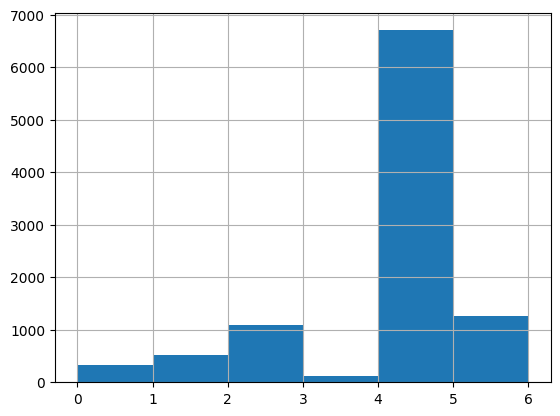

In [55]:
copy1["Label"].hist(bins = np.unique(copy1["Label"]))